# Testing with new data (MVP Com. Valenciana)

<img src="../images/04.jpg" width="600"/>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import datetime as dt
from tools import dataoveriew, plot_roc_curve, plot_confusion_matrix
from datetime import datetime
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pickle

pd.options.display.max_columns = None

class_names = ['Activo','Baja']

%matplotlib inline

In [2]:
data = pd.read_excel('../data/test_feb21.xlsx')
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes
0,2021-02-01,550000,Domusa,Murcia,Hombre,España,1958-10-06,Propiedad Total,Jubilado,Casado,1200,12,2021-02-01,ACTIVO,Piso,Financiado,Mas de 500 EUR,1099,NaN,0,237.06
1,2021-02-01,550001,Domusa,Valencia,Hombre,España,1974-01-29,Alquiler,Autonomo,Casado,1400,14,2021-02-01,ACTIVO,Tienda,Financiado,0 - 100 EUR,499,NaN,0,272.03
2,2021-02-01,550002,Domusa,Murcia,Hombre,España,1947-02-02,Propiedad Total,Jubilado,Casado,1500,14,2021-02-01,ACTIVO,Chalet,Financiado,200 - 300 EUR,599,NaN,0,203.33
3,2021-02-01,550003,Domusa,Barcelona,Hombre,Africa,1963-02-02,Alquiler,Trabajo Fijo,Casado,1500,14,2021-02-01,ACTIVO,Piso,Financiado,100 - 200 EUR,499,NaN,0,22.12
4,2021-02-01,550004,Domusa,Madrid,Hombre,España,1965-02-11,Propiedad Total,Autonomo,Casado,1200,12,2021-04-07,BAJA,Piso,Financiado,Promo 0 EUR,399,1.0,3,34.91


In [3]:
data.shape

(10243, 21)

In [4]:
data.isnull().sum()

Fecha Alta              0
Cliente                 0
Modelo Caldera          0
Provincia               0
Gender                  0
Pais                    0
Born Date              74
Tipo Propiedad          0
Situacion Laboral       0
Estado Civil            0
Ingresos                0
Pagos Anuales           0
Fecha Estado            0
Estado                  0
Tipo Inmueble           0
Financiado              0
Precio Contado          0
Precio Total            0
Quejas               9909
Incidencias             0
Consumo Mes             0
dtype: int64

In [5]:
data['Quejas'] = data['Quejas'].replace(np.nan, 0).astype('int')
data['Cliente'] = data['Cliente'].astype('str')
data['Estado'] = data['Estado'].astype('str').str.strip()
data['Estado'] = data['Estado'].replace({'ACTIVO': 0, 'BAJA': 1}).astype(int)
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes
0,2021-02-01,550000,Domusa,Murcia,Hombre,España,1958-10-06,Propiedad Total,Jubilado,Casado,1200,12,2021-02-01,0,Piso,Financiado,Mas de 500 EUR,1099,0,0,237.06
1,2021-02-01,550001,Domusa,Valencia,Hombre,España,1974-01-29,Alquiler,Autonomo,Casado,1400,14,2021-02-01,0,Tienda,Financiado,0 - 100 EUR,499,0,0,272.03
2,2021-02-01,550002,Domusa,Murcia,Hombre,España,1947-02-02,Propiedad Total,Jubilado,Casado,1500,14,2021-02-01,0,Chalet,Financiado,200 - 300 EUR,599,0,0,203.33
3,2021-02-01,550003,Domusa,Barcelona,Hombre,Africa,1963-02-02,Alquiler,Trabajo Fijo,Casado,1500,14,2021-02-01,0,Piso,Financiado,100 - 200 EUR,499,0,0,22.12
4,2021-02-01,550004,Domusa,Madrid,Hombre,España,1965-02-11,Propiedad Total,Autonomo,Casado,1200,12,2021-04-07,1,Piso,Financiado,Promo 0 EUR,399,1,3,34.91


In [6]:
provincias = ['Alicante', 'Valencia', 'Castellon']

data_com_val = data[data['Provincia'].isin(provincias)]
data_com_val.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes
1,2021-02-01,550001,Domusa,Valencia,Hombre,España,1974-01-29,Alquiler,Autonomo,Casado,1400,14,2021-02-01,0,Tienda,Financiado,0 - 100 EUR,499,0,0,272.03
15,2021-02-01,550018,Domusa,Valencia,Hombre,España,1950-04-03,Propiedad Total,Jubilado,Casado,1000,12,2021-02-01,0,Casa,Financiado,0 - 100 EUR,399,0,0,253.98
17,2021-02-01,550020,Biasi,Alicante,Mujer,Union Europea,1933-06-18,Propiedad Total,Jubilado,Viudo,1000,12,2021-02-01,0,Chalet,Financiado,300 - 400 EUR,699,0,0,287.64
23,2021-02-01,550026,Domusa,Valencia,Hombre,España,1961-03-28,Propiedad Total,Trabajo Fijo,Casado,1500,14,2021-02-01,0,Piso,Financiado,200 - 300 EUR,599,0,0,52.70
25,2021-02-01,550029,Domusa,Alicante,Hombre,España,1988-08-28,Propiedad Total,Trabajo Fijo,Soltero,1300,14,2021-02-01,0,Piso,Financiado,0 - 100 EUR,399,0,0,40.44


In [7]:
data_com_val.shape

(1363, 21)

In [8]:
data_com_val.to_excel('../data/test_com_valencia.xlsx', index = False)

In [9]:
data = pd.read_excel('../data/test_com_valencia.xlsx')
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes
0,2021-02-01,550001,Domusa,Valencia,Hombre,España,1974-01-29,Alquiler,Autonomo,Casado,1400,14,2021-02-01,0,Tienda,Financiado,0 - 100 EUR,499,0,0,272.03
1,2021-02-01,550018,Domusa,Valencia,Hombre,España,1950-04-03,Propiedad Total,Jubilado,Casado,1000,12,2021-02-01,0,Casa,Financiado,0 - 100 EUR,399,0,0,253.98
2,2021-02-01,550020,Biasi,Alicante,Mujer,Union Europea,1933-06-18,Propiedad Total,Jubilado,Viudo,1000,12,2021-02-01,0,Chalet,Financiado,300 - 400 EUR,699,0,0,287.64
3,2021-02-01,550026,Domusa,Valencia,Hombre,España,1961-03-28,Propiedad Total,Trabajo Fijo,Casado,1500,14,2021-02-01,0,Piso,Financiado,200 - 300 EUR,599,0,0,52.70
4,2021-02-01,550029,Domusa,Alicante,Hombre,España,1988-08-28,Propiedad Total,Trabajo Fijo,Soltero,1300,14,2021-02-01,0,Piso,Financiado,0 - 100 EUR,399,0,0,40.44


In [10]:
data['Born Date'].isnull().sum()

8

In [11]:
data['Born Date'] = data['Born Date'].replace(np.nan, datetime(1970, 1, 1))

In [12]:
data['Born Date'].isnull().sum()

0

In [13]:
data['Edad'] = 0
fecha = datetime(2021, 4, 18)

for i in range(len(data['Born Date'])):
    if data.loc[i, 'Estado'] == 0:
        data.loc[i,'Edad'] = ((fecha - data.loc[i,'Born Date']).days)/365
    else:
        data.loc[i,'Edad'] = ((data.loc[i,'Fecha Estado'] - data.loc[i,'Born Date']).days)/3655
                        
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad
0,2021-02-01,550001,Domusa,Valencia,Hombre,España,1974-01-29,Alquiler,Autonomo,Casado,1400,14,2021-02-01,0,Tienda,Financiado,0 - 100 EUR,499,0,0,272.03,47.249315
1,2021-02-01,550018,Domusa,Valencia,Hombre,España,1950-04-03,Propiedad Total,Jubilado,Casado,1000,12,2021-02-01,0,Casa,Financiado,0 - 100 EUR,399,0,0,253.98,71.090411
2,2021-02-01,550020,Biasi,Alicante,Mujer,Union Europea,1933-06-18,Propiedad Total,Jubilado,Viudo,1000,12,2021-02-01,0,Chalet,Financiado,300 - 400 EUR,699,0,0,287.64,87.893151
3,2021-02-01,550026,Domusa,Valencia,Hombre,España,1961-03-28,Propiedad Total,Trabajo Fijo,Casado,1500,14,2021-02-01,0,Piso,Financiado,200 - 300 EUR,599,0,0,52.70,60.098630
4,2021-02-01,550029,Domusa,Alicante,Hombre,España,1988-08-28,Propiedad Total,Trabajo Fijo,Soltero,1300,14,2021-02-01,0,Piso,Financiado,0 - 100 EUR,399,0,0,40.44,32.660274


In [14]:
for i in range(len(data['Edad'])):
    if data.loc[i, 'Edad'] < 18:
        data.loc[i, 'Edad'] = data['Edad'].mean()
    else:
        continue

In [15]:
data.loc[data['Edad'] <= 30, 'Rango_Edad'] = "18-30"
data.loc[(data['Edad'] > 30) & (data['Edad'] <= 40), 'Rango_Edad'] = "30-40"
data.loc[(data['Edad'] > 40) & (data['Edad'] <= 50), 'Rango_Edad'] = "40-50"
data.loc[(data['Edad'] > 50) & (data['Edad'] <= 60), 'Rango_Edad'] = "50-60"
data.loc[(data['Edad'] > 60) & (data['Edad'] <= 70), 'Rango_Edad'] = "60-70"
data.loc[(data['Edad'] > 70) & (data['Edad'] <= 80), 'Rango_Edad'] = "70-80"
data.loc[data['Edad'] > 80, 'Rango_Edad'] = "+80"
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad
0,2021-02-01,550001,Domusa,Valencia,Hombre,España,1974-01-29,Alquiler,Autonomo,Casado,1400,14,2021-02-01,0,Tienda,Financiado,0 - 100 EUR,499,0,0,272.03,47.249315,40-50
1,2021-02-01,550018,Domusa,Valencia,Hombre,España,1950-04-03,Propiedad Total,Jubilado,Casado,1000,12,2021-02-01,0,Casa,Financiado,0 - 100 EUR,399,0,0,253.98,71.090411,70-80
2,2021-02-01,550020,Biasi,Alicante,Mujer,Union Europea,1933-06-18,Propiedad Total,Jubilado,Viudo,1000,12,2021-02-01,0,Chalet,Financiado,300 - 400 EUR,699,0,0,287.64,87.893151,+80
3,2021-02-01,550026,Domusa,Valencia,Hombre,España,1961-03-28,Propiedad Total,Trabajo Fijo,Casado,1500,14,2021-02-01,0,Piso,Financiado,200 - 300 EUR,599,0,0,52.70,60.098630,60-70
4,2021-02-01,550029,Domusa,Alicante,Hombre,España,1988-08-28,Propiedad Total,Trabajo Fijo,Soltero,1300,14,2021-02-01,0,Piso,Financiado,0 - 100 EUR,399,0,0,40.44,32.660274,30-40


In [16]:
data.loc[data['Ingresos'] <= 1000, 'Income'] = "0-1000"
data.loc[(data['Ingresos'] > 1000) & (data['Ingresos'] <= 1500), 'Income'] = "1000-1500"
data.loc[(data['Ingresos'] > 1500) & (data['Ingresos'] <= 2000), 'Income'] = "1500-2000"
data.loc[(data['Ingresos'] > 2000) & (data['Ingresos'] <= 3000), 'Income'] = "2000-3000"
data.loc[data['Ingresos'] > 3000, 'Income'] = "+3000"
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad,Income
0,2021-02-01,550001,Domusa,Valencia,Hombre,España,1974-01-29,Alquiler,Autonomo,Casado,1400,14,2021-02-01,0,Tienda,Financiado,0 - 100 EUR,499,0,0,272.03,47.249315,40-50,1000-1500
1,2021-02-01,550018,Domusa,Valencia,Hombre,España,1950-04-03,Propiedad Total,Jubilado,Casado,1000,12,2021-02-01,0,Casa,Financiado,0 - 100 EUR,399,0,0,253.98,71.090411,70-80,0-1000
2,2021-02-01,550020,Biasi,Alicante,Mujer,Union Europea,1933-06-18,Propiedad Total,Jubilado,Viudo,1000,12,2021-02-01,0,Chalet,Financiado,300 - 400 EUR,699,0,0,287.64,87.893151,+80,0-1000
3,2021-02-01,550026,Domusa,Valencia,Hombre,España,1961-03-28,Propiedad Total,Trabajo Fijo,Casado,1500,14,2021-02-01,0,Piso,Financiado,200 - 300 EUR,599,0,0,52.70,60.098630,60-70,1000-1500
4,2021-02-01,550029,Domusa,Alicante,Hombre,España,1988-08-28,Propiedad Total,Trabajo Fijo,Soltero,1300,14,2021-02-01,0,Piso,Financiado,0 - 100 EUR,399,0,0,40.44,32.660274,30-40,1000-1500


In [26]:
# Días hasta el 18/04/2021, fecha de la extracción

data['Dias_Activo'] = 0
fecha = datetime(2021, 4, 18)

for i in range(len(data['Fecha Alta'])):
    data.loc[i,'Dias_Activo'] = (fecha - data.loc[i,'Fecha Alta']).days

data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad,Income,Dias_Activo
0,2021-02-01,550001,Domusa,Valencia,Hombre,España,1974-01-29,Alquiler,Autonomo,Casado,1400,14,2021-02-01,0,Tienda,Financiado,0 - 100 EUR,499,0,0,272.03,47.249315,40-50,1000-1500,76
1,2021-02-01,550018,Domusa,Valencia,Hombre,España,1950-04-03,Propiedad Total,Jubilado,Casado,1000,12,2021-02-01,0,Casa,Financiado,0 - 100 EUR,399,0,0,253.98,71.090411,70-80,0-1000,76
2,2021-02-01,550020,Biasi,Alicante,Mujer,Union Europea,1933-06-18,Propiedad Total,Jubilado,Viudo,1000,12,2021-02-01,0,Chalet,Financiado,300 - 400 EUR,699,0,0,287.64,87.893151,+80,0-1000,76
3,2021-02-01,550026,Domusa,Valencia,Hombre,España,1961-03-28,Propiedad Total,Trabajo Fijo,Casado,1500,14,2021-02-01,0,Piso,Financiado,200 - 300 EUR,599,0,0,52.70,60.098630,60-70,1000-1500,76
4,2021-02-01,550029,Domusa,Alicante,Hombre,España,1988-08-28,Propiedad Total,Trabajo Fijo,Soltero,1300,14,2021-02-01,0,Piso,Financiado,0 - 100 EUR,399,0,0,40.44,32.660274,30-40,1000-1500,76


In [27]:
# Copia para mostrar el resultado antes de realizar el escalado de variables

data_to_result = data.copy()

Transformaciones con `.pkl`

In [28]:
filename = '../mvp_pkl/dias_activo_sca.pkl'
scaler = pickle.load(open(filename, 'rb'))
data['Dias_Activo_sca'] = scaler.transform(data['Dias_Activo'].values.reshape(-1, 1))

In [29]:
filename = '../mvp_pkl/quejas_sca.pkl'
scaler = pickle.load(open(filename, 'rb'))
data['Quejas_sca'] = scaler.transform(data['Quejas'].values.reshape(-1, 1))

In [30]:
filename = '../mvp_pkl/incidencias_sca.pkl'
scaler = pickle.load(open(filename, 'rb'))
data['Incidencias_sca'] = scaler.fit_transform(data['Incidencias'].values.reshape(-1, 1))

In [31]:
filename = '../mvp_pkl/consumo_sca.pkl'
scaler = pickle.load(open(filename, 'rb'))
data['Consumo_sca'] = scaler.fit_transform(data['Consumo Mes'].values.reshape(-1, 1))

In [32]:
data_filtered = data[['Gender', 'Tipo Inmueble', 'Tipo Propiedad', 'Situacion Laboral', 'Estado Civil', 
                      'Provincia', 'Pais', 'Rango_Edad', 'Income', 'Precio Contado', 'Pagos Anuales', 'Dias_Activo_sca',
                      'Quejas_sca', 'Incidencias_sca', 'Consumo_sca', 'Estado']]
data_filtered.columns

Index(['Gender', 'Tipo Inmueble', 'Tipo Propiedad', 'Situacion Laboral',
       'Estado Civil', 'Provincia', 'Pais', 'Rango_Edad', 'Income',
       'Precio Contado', 'Pagos Anuales', 'Dias_Activo_sca', 'Quejas_sca',
       'Incidencias_sca', 'Consumo_sca', 'Estado'],
      dtype='object')

In [33]:
X = data_filtered.drop(['Estado'],axis=1)
y = data_filtered['Estado']

In [34]:
X.columns

Index(['Gender', 'Tipo Inmueble', 'Tipo Propiedad', 'Situacion Laboral',
       'Estado Civil', 'Provincia', 'Pais', 'Rango_Edad', 'Income',
       'Precio Contado', 'Pagos Anuales', 'Dias_Activo_sca', 'Quejas_sca',
       'Incidencias_sca', 'Consumo_sca'],
      dtype='object')

In [35]:
filename = '../mvp_pkl/TE_encoder.pkl'
TE_encoder = pickle.load(open(filename, 'rb'))
X = TE_encoder.transform(X)

In [36]:
X.head()

,Gender,Tipo Inmueble,Tipo Propiedad,Situacion Laboral,Estado Civil,Provincia,Pais,Rango_Edad,Income,Precio Contado,Pagos Anuales,Dias_Activo_sca,Quejas_sca,Incidencias_sca,Consumo_sca
0,0.253600,0.470280,0.508658,0.337908,0.219828,0.272935,0.254659,0.312628,0.257715,0.326792,0.234842,0.02459,0.0,0.0,0.387699
1,0.253600,0.207625,0.229333,0.144286,0.219828,0.272935,0.254659,0.117397,0.311213,0.326792,0.282987,0.02459,0.0,0.0,0.361681
2,0.278034,0.207887,0.229333,0.144286,0.183570,0.220812,0.250320,0.129642,0.311213,0.189836,0.282987,0.02459,0.0,0.0,0.410199
3,0.253600,0.210947,0.229333,0.219986,0.219828,0.272935,0.254659,0.143786,0.257715,0.185057,0.234842,0.02459,0.0,0.0,0.071552
4,0.253600,0.210947,0.229333,0.219986,0.370321,0.220812,0.254659,0.429920,0.257715,0.326792,0.234842,0.02459,0.0,0.0,0.053880


### Predicciones con modelos en `.pkl`

Random Forest Classifier:

              precision    recall  f1-score   support

           0       1.00      0.67      0.80      1359
           1       0.01      1.00      0.02         4

    accuracy                           0.67      1363
   macro avg       0.50      0.83      0.41      1363
weighted avg       1.00      0.67      0.80      1363



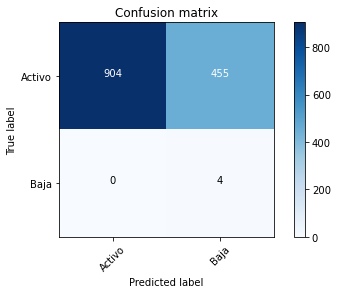

In [37]:
filename = '../mvp_pkl/rfc_model.pkl'
rfc = pickle.load(open(filename, 'rb'))

y_pred = rfc.predict(X)
print(classification_report(y, y_pred ))

cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

Regresión Logística:

              precision    recall  f1-score   support

           0       1.00      0.17      0.30      1359
           1       0.00      1.00      0.01         4

    accuracy                           0.18      1363
   macro avg       0.50      0.59      0.15      1363
weighted avg       1.00      0.18      0.30      1363



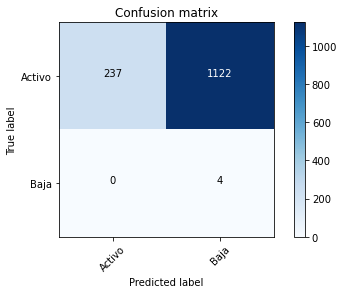

In [38]:
filename = '../mvp_pkl/LR_model.pkl'
LR = pickle.load(open(filename, 'rb'))

y_pred = LR.predict(X)
print(classification_report(y, y_pred ))

cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

Decission Tree Classifier:

              precision    recall  f1-score   support

           0       1.00      0.48      0.65      1359
           1       0.01      1.00      0.01         4

    accuracy                           0.49      1363
   macro avg       0.50      0.74      0.33      1363
weighted avg       1.00      0.49      0.65      1363



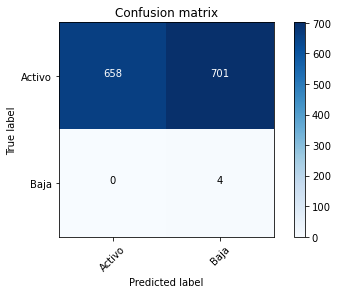

In [39]:
filename = '../mvp_pkl/DT_model.pkl'
DT = pickle.load(open(filename, 'rb'))

y_pred = DT.predict(X)
print(classification_report(y, y_pred ))

cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

Voting Classifier:

              precision    recall  f1-score   support

           0       1.00      0.43      0.60      1359
           1       0.01      1.00      0.01         4

    accuracy                           0.43      1363
   macro avg       0.50      0.72      0.31      1363
weighted avg       1.00      0.43      0.60      1363



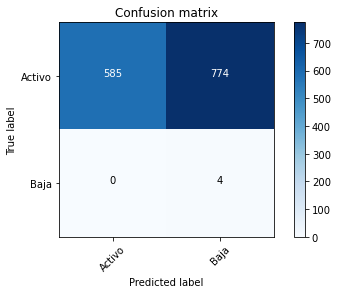

In [40]:
filename = '../mvp_pkl/voting_clf_model.pkl'
voting_clf = pickle.load(open(filename, 'rb'))

y_pred = voting_clf.predict(X)
print(classification_report(y, y_pred ))

cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

#### Exportar resultados

In [41]:
result_rfc = rfc.predict_proba(X)[:,1].reshape(-1, 1)
result_LR = LR.predict_proba(X)[:,1].reshape(-1, 1)
result_DT = DT.predict_proba(X)[:,1].reshape(-1, 1)
result_VC = voting_clf.predict_proba(X)[:,1].reshape(-1, 1)

In [42]:
df_rfc = pd.DataFrame(result_rfc, columns = ['Random Forest'])
df_LR = pd.DataFrame(result_LR, columns = ['Logistic Regression'])
df_DT = pd.DataFrame(result_DT, columns = ['Decission Tree'])
df_VC = pd.DataFrame(result_VC, columns = ['Voting Classifier'])

In [43]:
result = pd.concat([data_to_result, df_rfc, df_LR, df_DT, df_VC], axis = 1)
result.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad,Income,Dias_Activo,Random Forest,Logistic Regression,Decission Tree,Voting Classifier
0,2021-02-01,550001,Domusa,Valencia,Hombre,España,1974-01-29,Alquiler,Autonomo,Casado,1400,14,2021-02-01,0,Tienda,Financiado,0 - 100 EUR,499,0,0,272.03,47.249315,40-50,1000-1500,76,0.624957,0.947624,0.602022,0.722555
1,2021-02-01,550018,Domusa,Valencia,Hombre,España,1950-04-03,Propiedad Total,Jubilado,Casado,1000,12,2021-02-01,0,Casa,Financiado,0 - 100 EUR,399,0,0,253.98,71.090411,70-80,0-1000,76,0.479204,0.669719,0.447036,0.541128
2,2021-02-01,550020,Biasi,Alicante,Mujer,Union Europea,1933-06-18,Propiedad Total,Jubilado,Viudo,1000,12,2021-02-01,0,Chalet,Financiado,300 - 400 EUR,699,0,0,287.64,87.893151,+80,0-1000,76,0.232990,0.529972,0.251558,0.336703
3,2021-02-01,550026,Domusa,Valencia,Hombre,España,1961-03-28,Propiedad Total,Trabajo Fijo,Casado,1500,14,2021-02-01,0,Piso,Financiado,200 - 300 EUR,599,0,0,52.70,60.098630,60-70,1000-1500,76,0.064046,0.329370,0.213831,0.206997
4,2021-02-01,550029,Domusa,Alicante,Hombre,España,1988-08-28,Propiedad Total,Trabajo Fijo,Soltero,1300,14,2021-02-01,0,Piso,Financiado,0 - 100 EUR,399,0,0,40.44,32.660274,30-40,1000-1500,76,0.478881,0.688567,0.659666,0.589452


In [44]:
result.to_excel('../data/result_test_mvp.xlsx', index=False)